## Fixed Income Analysis -  Relative Value Trades

* [1. Bootstrapping](#1)
* [2. Cubic Splines](#2)
* [3. Nelson Siegel Model](#3)
* [4. Hedging](#4)
* [5. Portfolio Strategy - Steeepening](#5)

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
from datetime import date
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

PATH = 'data.xls'

### 1. Bootstrapping
<a id='1'></a>

In [2]:
# Get the df from the excel file
initial_date = date(2003, 8, 15)
df_bootstrap = pd.read_excel("data.xls", sheet_name="Exhibit 1", skiprows=1, header=1, parse_dates=['Maturity Date'])[:-2]
df_bootstrap['Maturity'] = (df_bootstrap['Maturity Date'] - pd.to_datetime(initial_date)).dt.days / 365
df_bootstrap['Maturity'] = df_bootstrap['Maturity'].round(1)

df_bootstrap.head()

,Coupon Rate (%),Maturity Date,Current Price,Maturity
0,3,2004-02-15,101.0544,0.5
1,2.125,2004-08-15,100.9254,1.0
2,1.5,2005-02-15,99.8942,1.5
3,6.5,2005-08-15,109.0934,2.0
4,5.625,2006-02-15,108.4380,2.5


In [3]:
freq = 2  # Assuming semi-annual coupon payments
zero_coupon_yield_list = []

# Compute the zero coupon yield
def zero_coupon_yield(maturity: float, coupon: float, current_price: float):
    # Compute the number of cash flows (i.e., periods based on maturity and frequency)
    sum_cash_flows = 0
    number_of_cash_flows = int(maturity * freq) # Multiply maturity in years by frequency (e.g., 2 for semi-annual)

    if zero_coupon_yield_list:
        for i in range(1, number_of_cash_flows):
            # Discount each coupon payment by the appropriate zero-coupon yield for that period
            cash_flow = (coupon / freq) / (1 + zero_coupon_yield_list[i-1] / freq)**i
            sum_cash_flows += cash_flow

    # Remaining price after deducting coupon cash flows
    remaining_price = current_price - sum_cash_flows

    # Calculate zero-coupon yield (final maturity value and last coupon discounted)
    zero_coupon_yield = (((100 + (coupon / freq)) / remaining_price)**(1 / number_of_cash_flows) - 1) * freq
    zero_coupon_yield_list.append(zero_coupon_yield)

    return zero_coupon_yield

# Apply function to the DataFrame
df_bootstrap['Zero Coupon Yield'] = df_bootstrap.apply(lambda row: zero_coupon_yield(row['Maturity'], row['Coupon Rate (%)'], row['Current Price']), axis=1)

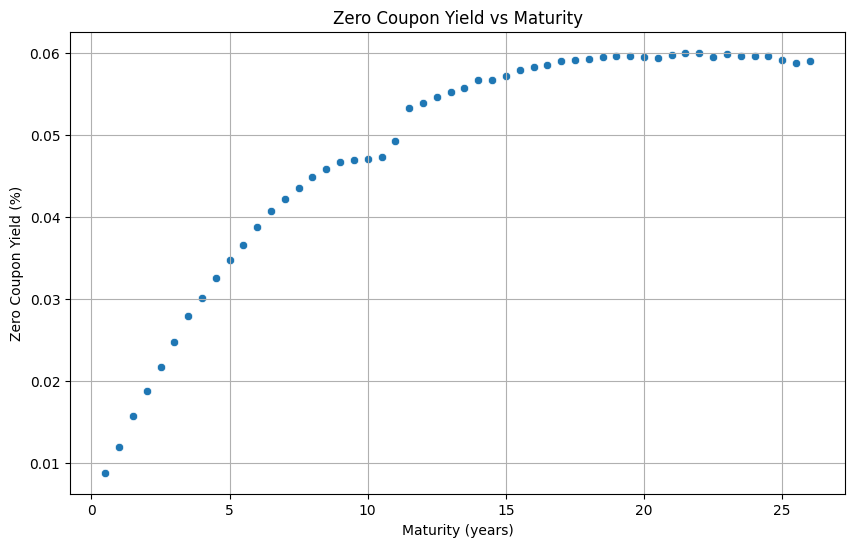

In [5]:
# Plot results 
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Maturity', y='Zero Coupon Yield', data=df_bootstrap, marker='o')
plt.title('Zero Coupon Yield vs Maturity')
plt.xlabel('Maturity (years)')
plt.ylabel('Zero Coupon Yield (%)')
plt.grid(True)
plt.show()

#### We compare it with the Deutsche Bank research analysis

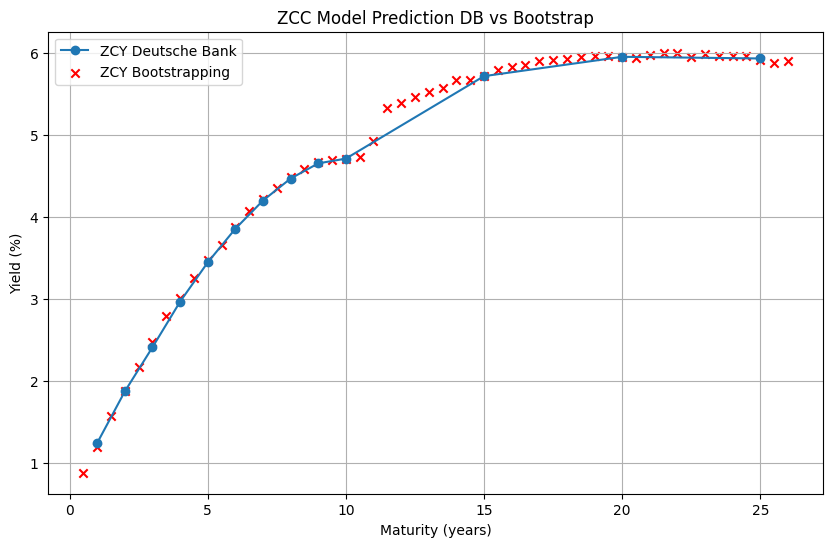

In [7]:
# Import curve from Exhibit 4 from Deutsche Bank
df_db = pd.read_excel("data.xls", sheet_name="Exhibit 4 ", skiprows=1, header=1)[:-4]
df_db['Model Prediction'] = df_db['Model Prediction (BEY)'].str.rstrip('%').astype('float') / 100.0

# Convert 'Maturity (years)' in df_db to numeric values
df_db['Maturity (years)'] = df_db['Maturity (years)'].str.rstrip('y').astype(float)

# Plot the two curves together
plt.figure(figsize=(10, 6))
plt.plot(df_db['Maturity (years)'], df_db['Model Prediction'] * 100, marker='o', label='ZCY Deutsche Bank')
plt.scatter(df_bootstrap['Maturity'], df_bootstrap['Zero Coupon Yield'] * 100, marker='x', label='ZCY Bootstrapping', color='red')
plt.title('ZCC Model Prediction DB vs Bootstrap')
plt.xlabel('Maturity (years)')
plt.ylabel('Yield (%)')
plt.grid(True)
plt.legend()
plt.show()

Deutsche Bank should buy bonds with market yields above model predictions (undervalued) and sell those below (overvalued), focusing on 10-15 year maturities. However, older, off-the-run bonds are less liquid, costlier to trade, and harder to source, with higher repo rates and transaction costs potentially reducing profits. Managing liquidity and availability risks is key to success.

### 2. Cubic splines
<a id='2'></a>

In [8]:
from scipy.interpolate import LSQUnivariateSpline

def fit_cubic_spline(df, knots):
    # Create LSQ Univariate Spline interpolation based on the knots and their yields
    cubic_spline = LSQUnivariateSpline(df['Maturity'], df['Zero Coupon Yield'], knots, k=3)

    # Define a fine range of maturities for smooth plotting and get the interpolated yields
    fine_maturities = np.linspace(df['Maturity'].min(), df['Maturity'].max(), 500)
    spline_yields = cubic_spline(fine_maturities)
    
    return fine_maturities, spline_yields

# Define the knots for the cubic spline (2-, 5-, 10-, 15-, and 20-year maturities)
knots = [2, 5, 10, 15, 20]
fine_maturities, spline_yields = fit_cubic_spline(df_bootstrap, knots)

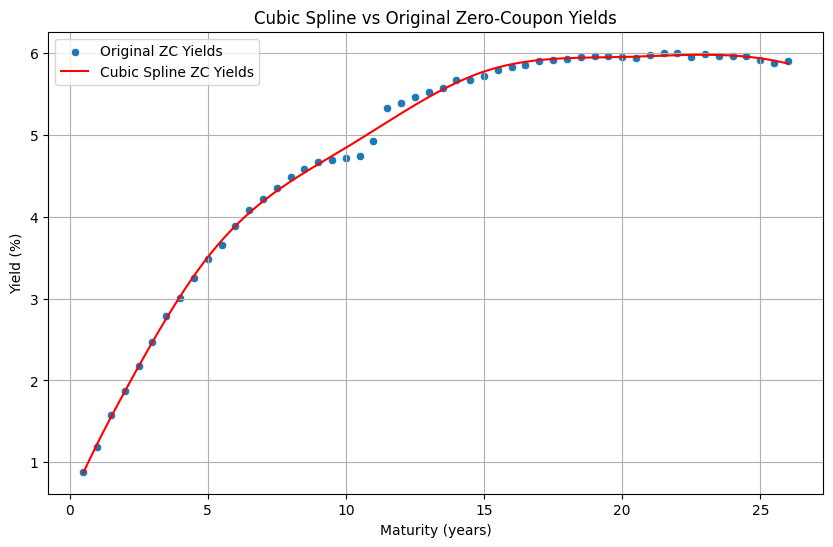

In [10]:
# Plot the original zero-coupon yields vs. the cubic spline yields
def plot_spline_vs_original(fine_maturities, spline_yields, maturities, zero_coupon_yields):
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=maturities, y=zero_coupon_yields * 100, marker='o', label='Original ZC Yields')
    sns.lineplot(x=fine_maturities, y=spline_yields * 100, label='Cubic Spline ZC Yields', color='red')
    plt.title('Cubic Spline vs Original Zero-Coupon Yields')
    plt.xlabel('Maturity (years)')
    plt.ylabel('Yield (%)')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_spline_vs_original(fine_maturities, spline_yields, df_bootstrap['Maturity'], df_bootstrap['Zero Coupon Yield'])

The cubic spline is ideal for liquid markets with closely spaced maturities, providing smooth yield changes, while bootstrapping captures abrupt shifts in irregular markets. For example, bootstrapping reveals a yield jump around 11-12 years (a buy signal), which the cubic spline smooths over due to its broader knots. Model choice depends on market conditions.

### 3. Nelson Siegel model
<a id='3'></a>

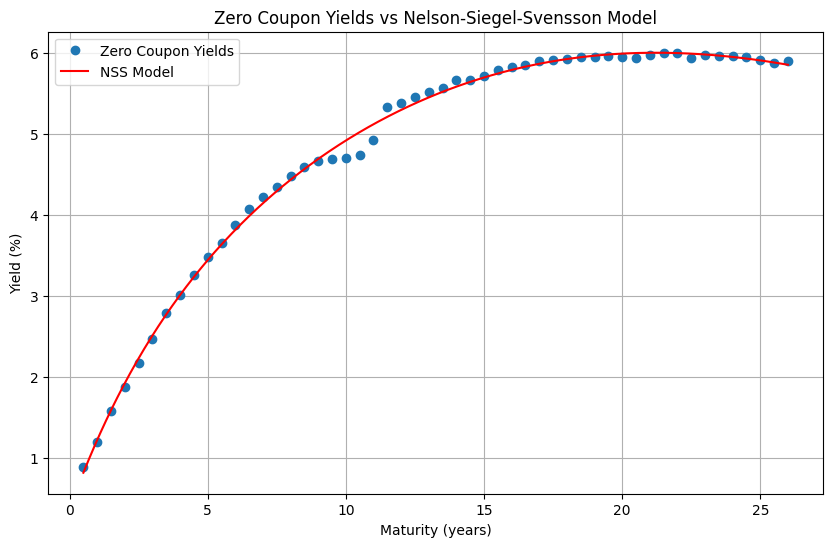

In [11]:
from scipy.optimize import curve_fit

# Define the Nelson-Siegel-Svensson model
def nss_model(t, beta0, beta1, beta2, beta3, lambda1, lambda2):
    term1 = beta0
    term2 = beta1 * (1 - np.exp(-lambda1 * t)) / (lambda1 * t)
    term3 = beta2 * ((1 - np.exp(-lambda1 * t)) / (lambda1 * t) - np.exp(-lambda1 * t))
    term4 = beta3 * ((1 - np.exp(-lambda2 * t)) / (lambda2 * t) - np.exp(-lambda2 * t))
    return term1 + term2 + term3 + term4

# Initial guess for the parameters and fit the NSS model to the zero-coupon yields
initial_guess = [0.03, -0.02, 0.02, 0.01, 1.0, 1.0]
params, _ = curve_fit(nss_model, df_bootstrap['Maturity'], df_bootstrap['Zero Coupon Yield'], p0=initial_guess)

# Generate the fitted yields using the estimated parameters
fitted_yields = nss_model(fine_maturities, *params)

# Plot the zero-coupon yields and the fitted NSS model
plt.figure(figsize=(10, 6))
plt.plot(df_bootstrap['Maturity'], df_bootstrap['Zero Coupon Yield'] * 100, 'o', label='Zero Coupon Yields')
plt.plot(fine_maturities, fitted_yields * 100, '-', label='NSS Model', color='red')
plt.title('Zero Coupon Yields vs Nelson-Siegel-Svensson Model')
plt.xlabel('Maturity (years)')
plt.ylabel('Yield (%)')
plt.legend()
plt.grid(True)
plt.show()

The Nelson-Siegel-Svensson (NSS) model fits the zero-coupon yield curve by capturing its level, slope, and curvature using parameters beta0, beta1, beta2, beta3, lambda1, and lambda2. It creates a smooth curve optimized via curve_fit but may over/underestimate yields in certain ranges (e.g., 8-13 years). A more granular approach, fitting localized maturity subsets and averaging, can improve accuracy, as applied during my EGB trading internship. Compared to cubic splines, which excel at capturing localized variations but risk overfitting, the NSS model provides a broader, smoother representation, ideal for long-range yield dynamics.

### 4. Hedging
<a id='4'></a>

We adjust the function from the Step 1 for the bump

In [13]:
# Apply function to the DataFrame
df_hedge = df_bootstrap.copy()
bump_tuple = (10, 0.005)

# Adjust the zero coupon yield based on bump_tuple
maturity, bump = bump_tuple
df_hedge.loc[df_hedge['Maturity'] == maturity, 'Zero Coupon Yield'] += bump

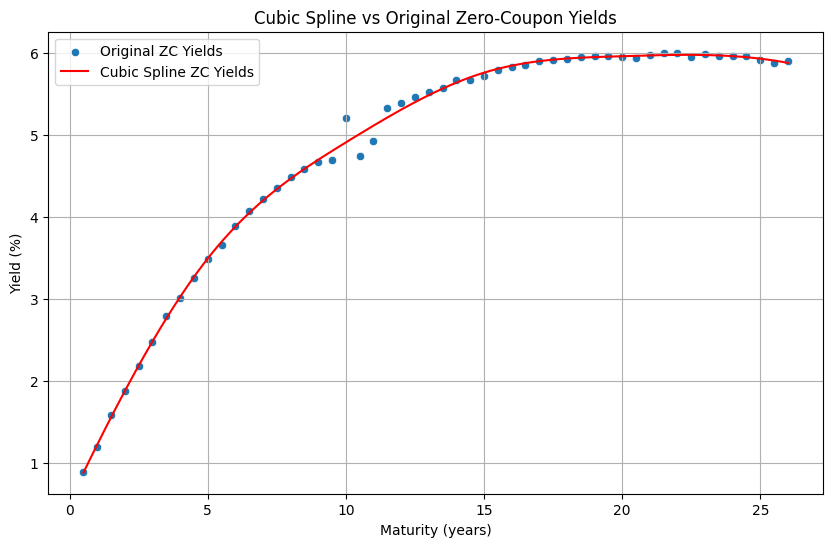

In [16]:
# Define the knots for the cubic spline (2-, 5-, 10-, 15-, and 20-year maturities)
knots = [2, 5, 10, 15, 20]
fine_maturities_cubic, spline_yields_cubic = fit_cubic_spline(df_hedge, knots)

plot_spline_vs_original(fine_maturities_cubic, spline_yields_cubic, df_hedge['Maturity'], df_hedge['Zero Coupon Yield'])

A 50 bps shock to the 10-year rate shifts the data point above the cubic spline curve, but the curve itself remains largely unchanged. This reflects the spline's design to prioritize smoothness through fixed knots over dynamic adjustment to individual points.

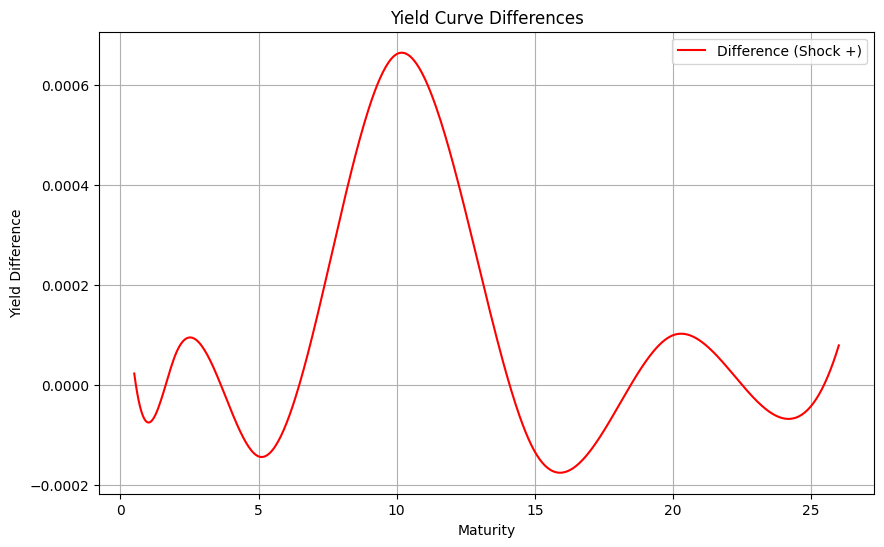

In [17]:
fine_maturities, spline_yields = fit_cubic_spline(df_bootstrap, knots)

# Calculate and Plot the differences between the two curves
diff_shocked_plus = spline_yields_cubic - spline_yields 
plt.figure(figsize=(10, 6))
plt.plot(fine_maturities, diff_shocked_plus, label='Difference (Shock +)', color='red')
plt.xlabel('Maturity')
plt.ylabel('Yield Difference')
plt.title('Yield Curve Differences')
plt.legend()
plt.grid(True)

plt.show()

#### We own a $1 million portfolio equally invested across all bonds. We compute the KRD of our portfolio;

In [18]:
# Define constants and prepare DataFrame
df_bootstrap_all = df_bootstrap.copy()
freq = 2  
zero_coupon_yield_index = df_bootstrap_all[['Maturity', 'Zero Coupon Yield']]
bump_tuple = (10, 0.005)  # (maturity, bump (%))

# Define price change function
def price_change(maturity: float, coupon: float, current_price: float, zero_coupon_yield_index: pd.DataFrame, bump_tuple: tuple):
    # Compute the number of cash flows
    new_bond_price = 0
    number_of_cash_flows = int(maturity * freq)
    zero_coupon_yield_index_prov = zero_coupon_yield_index.copy()

    # Apply bump to zero coupon yields as per bump_tuple
    bump_maturity, bump = bump_tuple
    zero_coupon_yield_index_prov.loc[zero_coupon_yield_index_prov['Maturity'] == bump_maturity, 'Zero Coupon Yield'] += bump

    # Calculate bond price after applying bump
    for i in range(number_of_cash_flows):
        # Get the corresponding zero-coupon yield for the period
        yield_for_period = zero_coupon_yield_index_prov.iloc[i]['Zero Coupon Yield']
        
        # Calculate cash flow
        cash_flow = (100 if i == number_of_cash_flows -1 else 0) + coupon / freq
        discounted_cash_flow = cash_flow / (1 + yield_for_period / freq) ** (i + 1)
        
        # Sum discounted cash flows
        new_bond_price += discounted_cash_flow

    # Calculate price change percentage
    total_price_change = (new_bond_price - current_price) / current_price 
    return total_price_change

# Apply function to each row in the DataFrame
df_bootstrap_all['Price Change (%)'] = df_bootstrap_all.apply(
    lambda row: price_change(row['Maturity'], row['Coupon Rate (%)'], row['Current Price'], zero_coupon_yield_index, bump_tuple),
    axis=1
)

In [19]:
# Calculate the percentage change in price and create a new column
total_price_change = round(df_bootstrap_all['Price Change (%)'].sum() / df_bootstrap_all.shape[0] * 1_000_000, 2)
print(total_price_change)

-1169.34


The portfolio’s Key Rate Duration (KRD) to a 50 bps upward shock in the 10-year yield results in a value change of -1,169.34. This indicates that the portfolio would lose approximately $1,169 if the 10-year rate increased by 50 basis points, reflecting a negative sensitivity to movements at this key maturity. By calculating each bond’s price adjustment under the rate shock and averaging the changes, we capture the portfolio's specific exposure to the 10-year rate, showing a moderate level of interest rate risk focused around this maturity.

#### We estimate and plot the KRDs of our portfolio across all maturities by applying the same shock individually to all zero-coupon yields. We then analyze and interpret the results.

In [20]:
# Loop through each maturity in df_bootstrap and compute total_price_change
total_price_changes = []
for maturity in df_bootstrap_all['Maturity']:
    bump_tuple = (maturity, bump)
    df_bootstrap_all['Price Change (%)'] = df_bootstrap_all.apply(
        lambda row: price_change(row['Maturity'], row['Coupon Rate (%)'], row['Current Price'], zero_coupon_yield_index, bump_tuple),
        axis=1
    )
    total_price_change = df_bootstrap_all['Price Change (%)'].sum() / df_bootstrap_all.shape[0] * 1_000_000
    total_price_changes.append(total_price_change)

# Add the Total Portfolio Changes as a new column in df_bootstrap_all
df_bootstrap_all.drop('Price Change (%)', axis=1, inplace=True)
df_bootstrap_all['Total Portfolio Change'] = total_price_changes

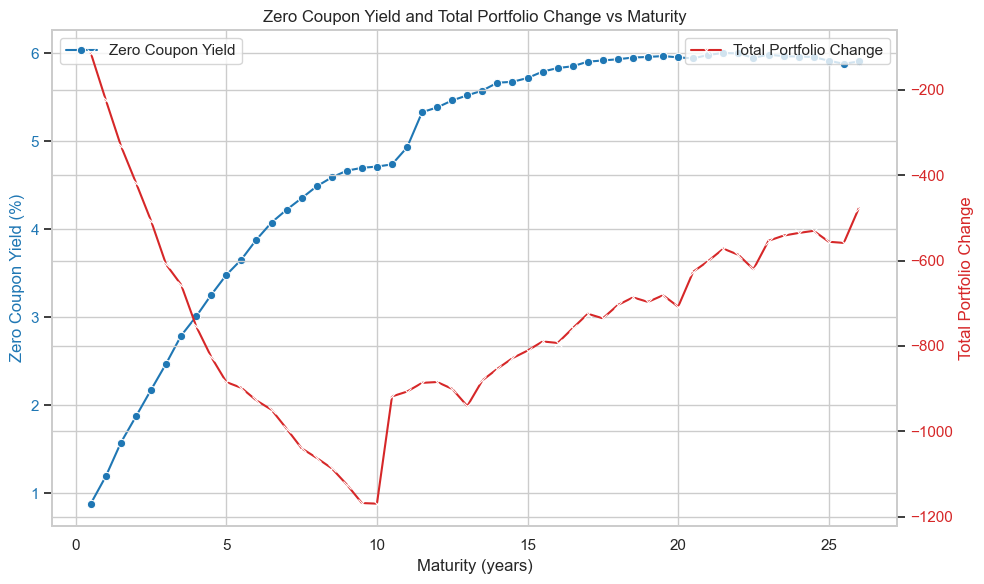

In [21]:
# Set the aesthetic style of the plots
sns.set(style="whitegrid")

fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot Zero Coupon Yield on the first y-axis
ax1.set_xlabel('Maturity (years)')
ax1.set_ylabel('Zero Coupon Yield (%)', color='tab:blue')
sns.lineplot(x=df_bootstrap_all['Maturity'], y=df_bootstrap_all['Zero Coupon Yield'] * 100, marker='o', color='tab:blue', label='Zero Coupon Yield', ax=ax1)
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Create a second y-axis to plot Total Portfolio Change
ax2 = ax1.twinx()
ax2.set_ylabel('Total Portfolio Change', color='tab:red')
sns.lineplot(x=df_bootstrap_all['Maturity'], y=df_bootstrap_all['Total Portfolio Change'], marker='x', color='tab:red', label='Total Portfolio Change', ax=ax2)
ax2.tick_params(axis='y', labelcolor='tab:red')

# Add a title and show the plot
plt.title('Zero Coupon Yield and Total Portfolio Change vs Maturity')
fig.tight_layout()
plt.show()

The 10-year bond shows the highest KRD impact due to its low 4% coupon, concentrating cash flows in the principal and increasing duration. This amplifies sensitivity to rate shocks compared to higher-coupon, shorter-duration bonds, highlighting the influence of coupons and maturities on portfolio yield sensitivity.

### 5. Portfolio strategy
<a id='5'></a>

We expect the bootstrapped zero-coupon curve from Step 1. to steepen according to the following function, where $ \epsilon $ is random noise and $ \bar{T} $ is the average bond maturity in our sample:

$
y_{Steepen}^T = y^T + \left[ \frac{(T - \bar{T})}{\bar{T}} \times 0.005 \right] + \epsilon
$ with 
$
\epsilon \sim \mathcal{N}(0, 0.0025)
$

We will plot the new curve based on our expectations against the bootstrapped zero-coupon curve. Additionally, we will separate the deterministic component of our expectations from the stochastic component originating from the random noise $ \epsilon $ term.


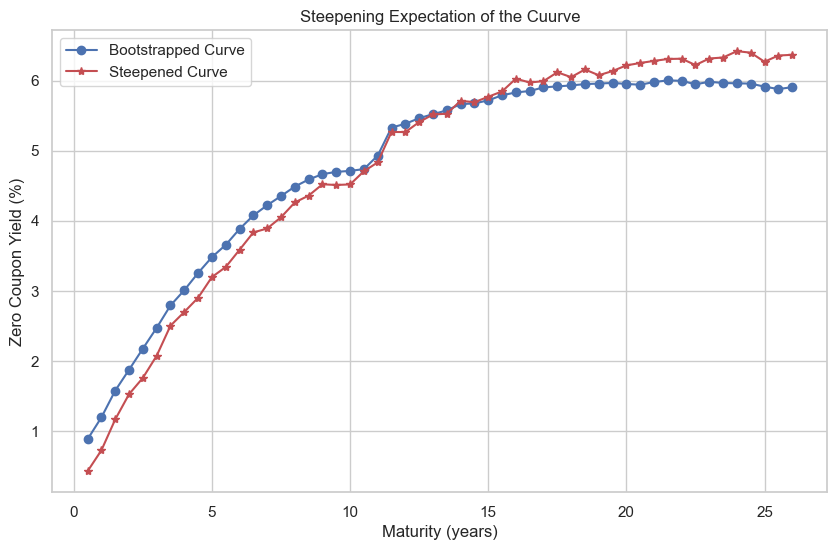

In [22]:
import numpy as np

# we set the seed for reproductivity
np.random.seed(42)

maturity_parameter = 0.005
noise_parameter = 0.0025
maturities_mean = df_bootstrap['Maturity'].mean()
df = pd.DataFrame()
df['Maturity'] = df_bootstrap['Maturity']
df['Coupon Rate (%)'] = df_bootstrap['Coupon Rate (%)']
df['Current Price'] = df_bootstrap['Current Price']
deterministic_component = df_bootstrap['Zero Coupon Yield'] + (df_bootstrap['Maturity'] - maturities_mean) / maturities_mean * maturity_parameter
noise = np.random.normal(0, np.sqrt(noise_parameter), len(df)) / 100
df['Steep. Yield'] = deterministic_component + noise

plt.figure(figsize=(10, 6))

plt.plot(df_bootstrap['Maturity'], df_bootstrap['Zero Coupon Yield'] * 100, marker='o', label='Bootstrapped Curve')
plt.plot(df['Maturity'], df['Steep. Yield'] * 100, marker='*', color='r', label='Steepened Curve')
plt.title('Steepening Expectation of the Cuurve')
plt.xlabel('Maturity (years)')
plt.ylabel('Zero Coupon Yield (%)')
plt.grid(True)
plt.legend()
plt.show()

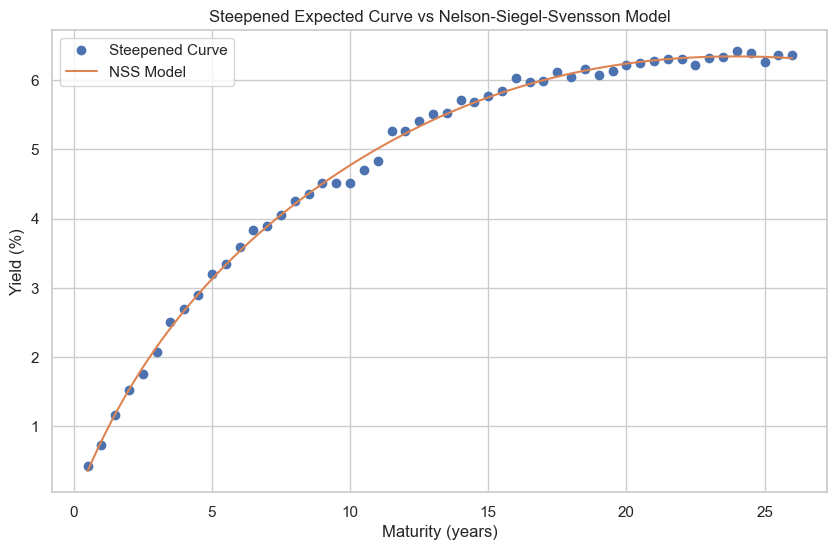

In [23]:
from scipy.optimize import curve_fit

# Define the Nelson-Siegel-Svensson model
def nss_model(t, beta0, beta1, beta2, beta3, lambda1, lambda2):
    term1 = beta0
    term2 = beta1 * (1 - np.exp(-lambda1 * t)) / (lambda1 * t)
    term3 = beta2 * ((1 - np.exp(-lambda1 * t)) / (lambda1 * t) - np.exp(-lambda1 * t))
    term4 = beta3 * ((1 - np.exp(-lambda2 * t)) / (lambda2 * t) - np.exp(-lambda2 * t))
    return term1 + term2 + term3 + term4

# Initial guess for the parameters and fit the NSS model to the zero-coupon yields
initial_guess = [0.03, -0.02, 0.02, 0.01, 1.0, 1.0]
params, _ = curve_fit(nss_model, df['Maturity'], df['Steep. Yield'], p0=initial_guess)

# Generate the fitted yields using the estimated parameters
fitted_yields = nss_model(fine_maturities, *params)

# Plot the zero-coupon yields and the fitted NSS model
plt.figure(figsize=(10, 6))
plt.plot(df['Maturity'], df['Steep. Yield'] * 100, 'o', label='Steepened Curve')
plt.plot(fine_maturities, fitted_yields * 100, '-', label='NSS Model')
plt.title('Steepened Expected Curve vs Nelson-Siegel-Svensson Model')
plt.xlabel('Maturity (years)')
plt.ylabel('Yield (%)')
plt.legend()
plt.grid(True)
plt.show()

Let's extract the yields given by the Nelson-Siegel-Svensson for the specific maturities we focus on

In [24]:
from scipy.interpolate import interp1d

# Create an interpolation function for the larger dataframe
interp_func = interp1d(fine_maturities, fitted_yields, kind='linear', fill_value='extrapolate')

# Interpolate yields for the maturities in the smaller dataframe
df['NSS Yield'] = interp_func(df['Maturity'])
df.sample(5)

,Maturity,Coupon Rate (%),Current Price,Steep. Yield,NSS Yield
12,6.5,6.5,114.9084,0.038325,0.037119
41,21.0,7.5,125.4466,0.062799,0.062863
28,14.5,9.125,140.7920,0.056908,0.056771
3,2.0,6.5,109.0934,0.015243,0.015284
5,3.0,2.375,99.7848,0.020726,0.021455


Let's compute the theorical price of these bonds using the yields provided by the Nelson-Siegel-Svensson model

In [25]:
face_value = 100

def compute_bond_price(df):

    bond_prices = []
    for i in df.index:

        coupon_payment = (df['Coupon Rate (%)'][i] / 2)
        periods = int(df['Maturity'][i] * freq)  
        
        # Calculate the bond price by summing the present value of each cash flow
        bond_price = 0
        for t in range(1, periods + 1):
            discount_factor = (1 + df['NSS Yield'][t-1] / 2) ** t
            bond_price += coupon_payment / discount_factor

        # Add the face value discounted back to the present
        bond_price += face_value / ((1 + df['NSS Yield'][i] / 2) ** periods)
        bond_prices.append(bond_price)

    df['NSS Price'] =bond_prices
        
    return df

df = compute_bond_price(df)

df['Spread'] = df['NSS Price'] - df['Current Price']

df.sample(5)

,Maturity,Coupon Rate (%),Current Price,Steep. Yield,NSS Yield,NSS Price,Spread
20,10.5,13.25,174.3251,0.047052,0.048940,174.649830,0.324730
34,17.5,7.875,128.4995,0.061177,0.060503,128.512132,0.012632
46,23.5,6.625,114.7086,0.063284,0.063419,112.672281,-2.036319
47,24.0,6.375,111.4036,0.064189,0.063431,109.288037,-2.115563
13,7.0,5.75,110.3894,0.038888,0.038868,112.560434,2.171034


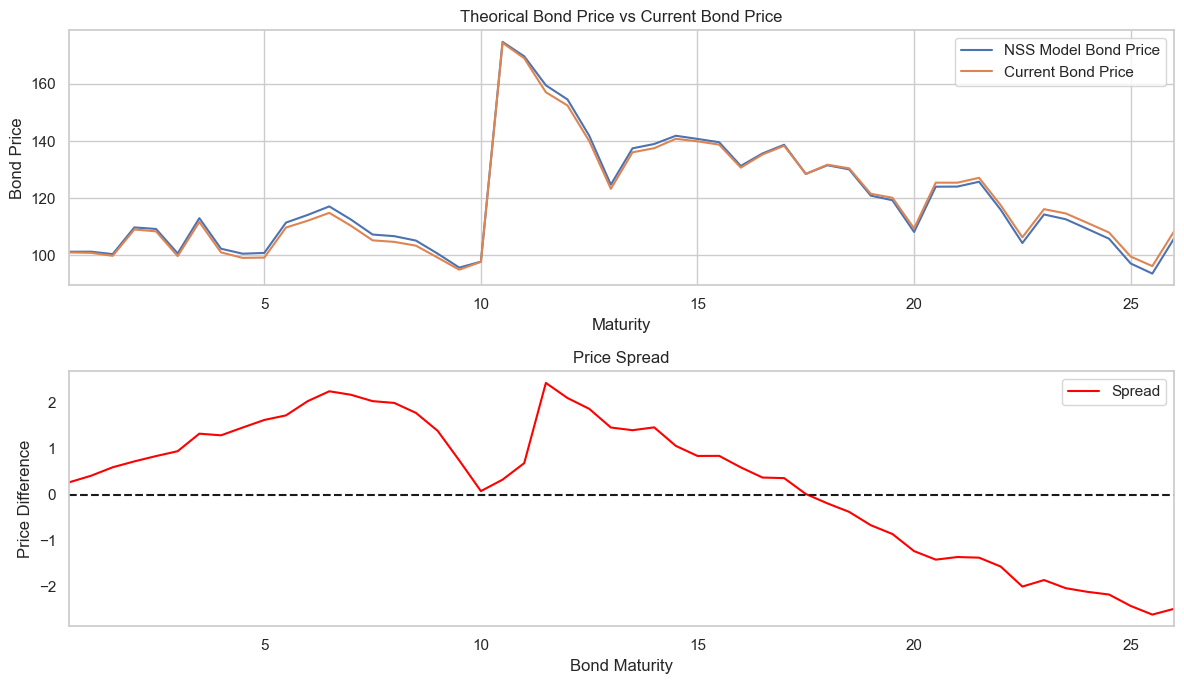

In [26]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 7))

ax1.plot(df['Maturity'], df['NSS Price'], label='NSS Model Bond Price')
ax1.plot(df['Maturity'], df['Current Price'], label='Current Bond Price')
ax1.set_title('Theorical Bond Price vs Current Bond Price')
ax1.set_xlabel('Maturity')
ax1.set_xlim(df['Maturity'].min(), df['Maturity'].max())
ax1.set_ylabel('Bond Price')
ax1.legend()

ax2.plot(df['Maturity'], df['Spread'], label='Spread', color='red')
ax2.plot(df['Maturity'], np.zeros(df.shape[0]), 'k--')
ax2.set_title('Price Spread')
ax2.set_xlabel('Bond Maturity')
ax2.set_xlim(df['Maturity'].min(), df['Maturity'].max())
ax2.set_ylabel('Price Difference')
ax2.grid()
ax2.legend()

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

The bonds where the spread is positive are undervalued (the current price is lower than the price given by the NSS model), and the bonds where the spread is negative are overvalued (the current price is higher than the price given by the NSS model). Then, the **cheap bonds** are those where the spread is significantly positive : the bonds that have a maturity between **4 years and 9 years and betwen 11 and 12 years**. On the contrary, **the most expensive bonds** are the ones that have a maturity between **22 and 26 years.**